# K-Means Clustering applied to Sporulation Dataset

## Introduction

This Jupyter Notebook contains all the code used to replicate the results from the paper [Comparisons and validation of statistical clustering techniques for microarray gene expression data](../docs/papers/A1-Comparison-Bioinformatics-2003-Datta.pdf), in particular, the application of *K-Means clustering* to the *Sporulation Dataset*, which contains data from the output of DNA microarrays, which captured the expression levels of nearly every yeast gene during sporulation, first published in the paper [Transcriptional Program of Sportulation in Budding Yeast](../docs/papers/A2-The%20Transcriptional%20Program%20of%20Sporulation%20in%20Budding%20Yeast.pdf).

In [71]:
# Import libraries
from typing import List, Tuple, Dict, Union # Typing for functions

import pandas as pd # DataFrame manipulation
import numpy as np # Vectorized operations for large data

import matplotlib.pyplot as plt # Data visualization
from matplotlib import rcParams # Params for in-line visualization
import seaborn as sns # Further visualization
import scienceplots # Plotting style settings
plt.style.use(['science', 'notebook', 'std-colors', 'grid'])
rcParams['figure.figsize'] = [10, 5]  # Set up image visualization params

from scipy.cluster.hierarchy import linkage # UPGMA algorithm
from scipy.spatial.distance import pdist # Compute the matrix distance
from sklearn.cluster import KMeans # K-Means code
from sklearn.metrics import silhouette_samples, silhouette_score # Silhouette validation metrics
from sklearn.preprocessing import StandardScaler # Import normalizing preprocessing step

## Methodology

This sections illustrates the pre-processing steps, hyperparameter tuning, plot generation, etc. That has been developed in order to obtain our results with the K-Means algorithm applied to the Sporulation Dataset.

In [72]:
# Load the Dataset
data = pd.read_csv('../data/sporulation-filtered.txt', delimiter="\t", header=None)
data.columns = data.iloc[0] # Set the first row as columns
data = data[1:] # Ignore first row
# Take a look at the first rows
data.head()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
1,YAL025C,"1,163781","-1,758143","-0,31495","0,283874","-0,6779","0,470183","0,833156"
2,YAL036C,"0,955552","-1,48956","-0,499057","-0,099143","-0,674453","1,414381","0,39228"
3,YAL040C,"1,454598","-0,735149","-0,073602","-0,618896","-0,789697","1,391507","-0,62876"
4,YDL037c,"1,698578","-1,268638","-0,375511","0,996817","-0,319158","-0,344837","-0,387251"
5,YDR184C,"1,302831","-1,338633","-0,555163","-0,101402","-0,674167","1,317301","0,049233"


In [73]:
# Take a look at the last rows
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"
475,"Mean 1,358206","-0,888829","-0,353535","-0,467139","-0,787436","0,1887355","0,949998",NaN
476,"stad 0,43970021","0,9559518","0,410392755","0,614475086","0,098266629","0,329643282","0,057125036",NaN


In [74]:
# Ignore last 2 rows, since they contains the mean and standard deviation of the columns
# also, they are incorrectly loaded, leaving NaN values for t11,5
data = data.iloc[:-2, :]
data.tail()

,Genes,t0,"t0,5",t2,t5,t7,t9,"t11,5"
470,YPL079W,"1,47357","-0,980588","0,187547","-0,775976","-1,067287","0,126038","1,036696"
471,YPL081W,"1,543327","-1,09","-0,374713","-0,780946","-0,671057","0,308319","1,065071"
472,YPL090C,"1,85523","-0,550056","-0,264951","-1,042622","-0,729874","-0,019525","0,751798"
473,YPL131W,"1,785611","-0,406223","-0,895333","-0,585125","-0,81687","0,003997","0,913943"
474,YPL198W,"1,552631","-0,019515","-0,39212","-1,218152","-0,896972","-0,092712","1,06684"


#### Exploratory Data Analysis

1. **Check for Missing values**

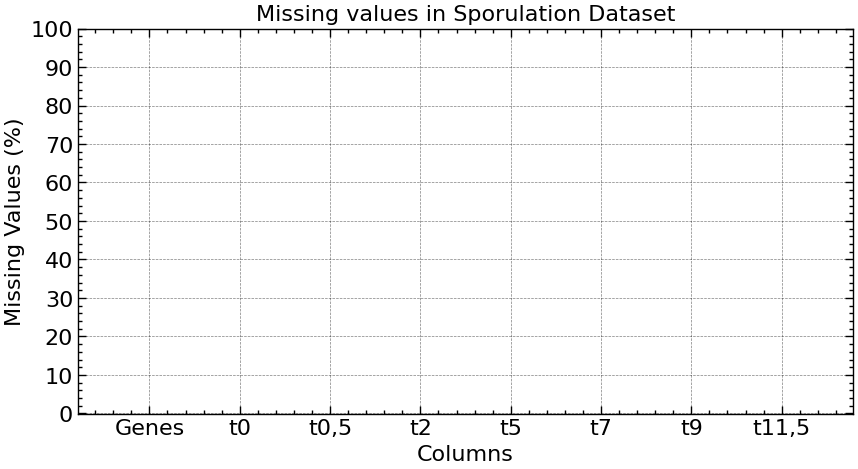

In [75]:
missing = data.isnull().sum() # Compute the sum of True values for each column
missing = missing / data.shape[0]
# Plot the results
plt.bar(x=missing.index, height=missing.values)
plt.title('Missing values in Sporulation Dataset')
plt.ylabel('Missing Values (%)')
plt.yticks(range(0, 110, 10))
plt.xlabel('Columns')
plt.show()

We've not found any missing values in the dataset. Since data is given as an `object` type (string), we must convert all the rows except for the first one to `float`. 

In [76]:
# Now that we know there are not any NA values, convert the string values 
# to float: Replace ',' with '.' and change data type
genes_col = data['Genes']

# Step 2: Drop the 'Genes' column from the DataFrame
data = data.drop(columns=['Genes'])

# Step 3: Replace commas with periods and convert the remaining columns to float
data = data.replace(',', '.', regex=True).astype(float)

# Step 4: Paste the 'Genes' column back into the DataFrame
data['Genes'] = genes_col

# Step 5: Move 'Genes' column to the first position
data = data[['Genes'] + [col for col in data.columns if col != 'Genes']]

data.dtypes

0
Genes     object
t0       float64
t0,5     float64
t2       float64
t5       float64
t7       float64
t9       float64
t11,5    float64
dtype: object

2. **Distribution of Gene Expression Levels**

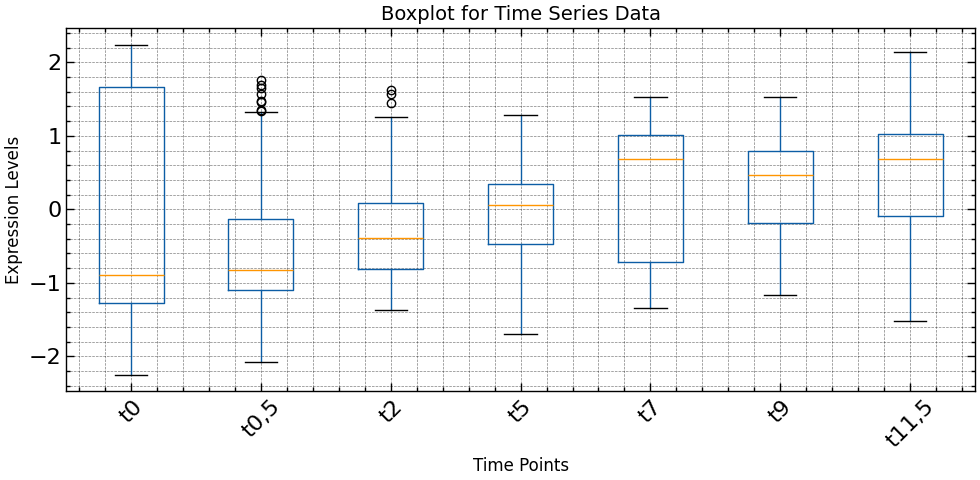

In [77]:
# Create a boxplot for all numerical columns
data.boxplot()

# Customize the plot
plt.title("Boxplot for Time Series Data", fontsize=14)
plt.ylabel("Expression Levels", fontsize=12)
plt.xlabel("Time Points", fontsize=12)

# Adjust gridlines and axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.tight_layout()

# Show the plot
plt.show()

It seems that gene expression level vary over time. At `t=0` the process seems to be unstable, showing data with a higher standard deviation but a lower mean value, indicating that the majority of the genes have negative expression levels, indicating that the expression level at this time points is bellow the refere level. As we progress over time, the mean expression value goes up, until it stabilizes around `t=7`, the dispersion of the data also becomes lower, meaning that the sporulation process is becoming more coordinated. At `t=0.5` and `t=2` there are a few genes that are over-expressed.  

3. **Correlation between Time Points**

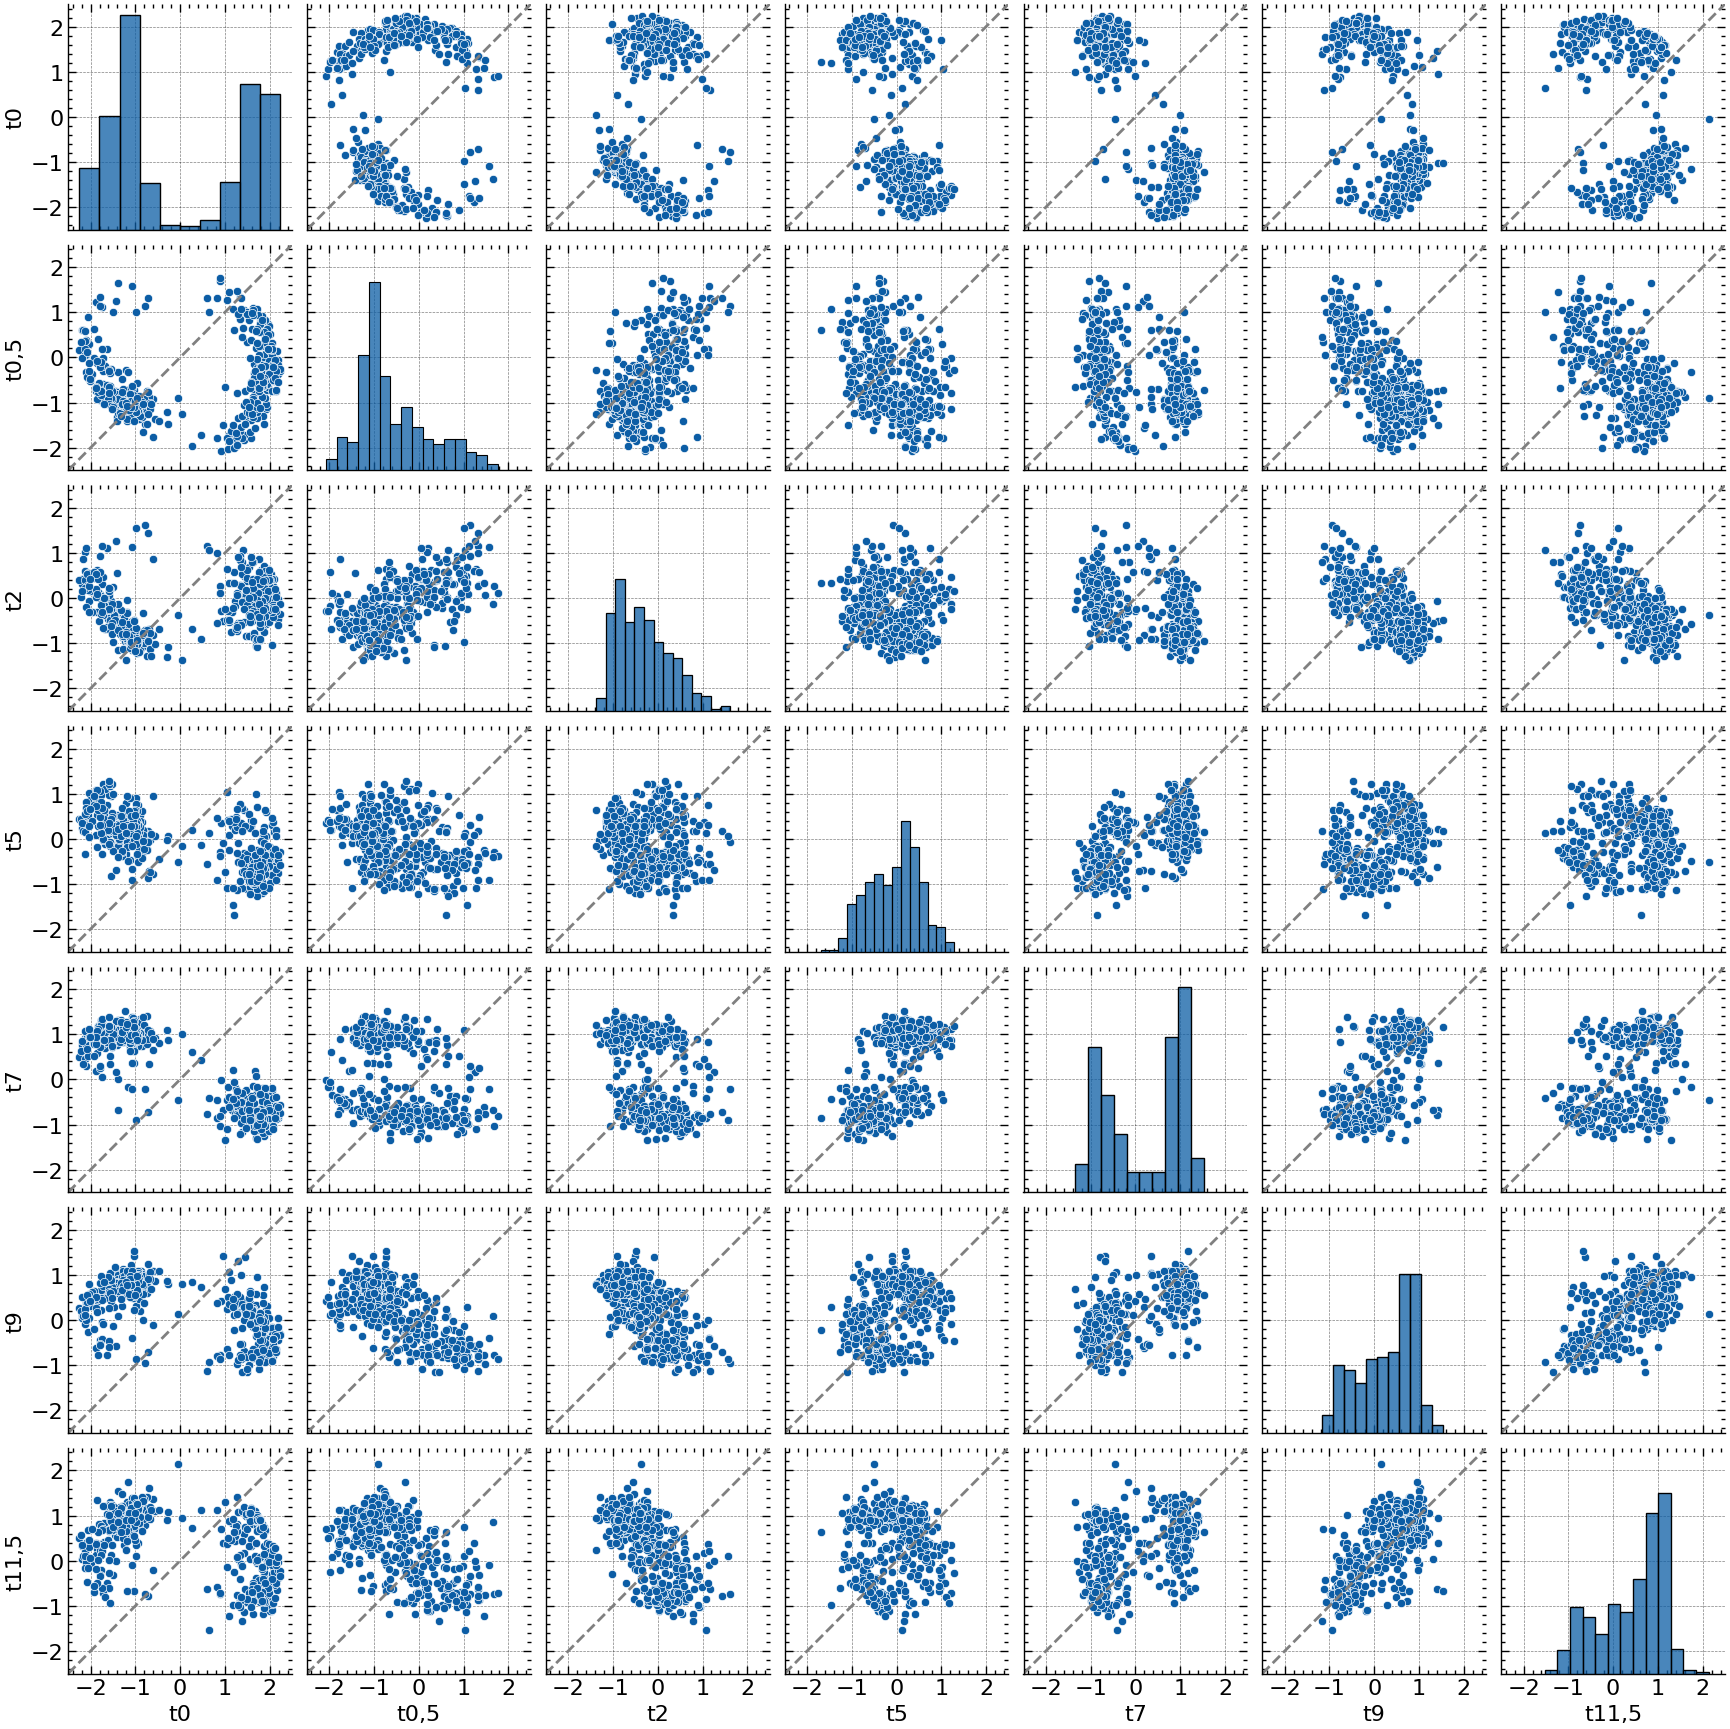

In [78]:
# Set a range
expression_range = [-2.5, 2.5]

# Create the pairplot
pairplot = sns.pairplot(data[data.columns[1:]])

# Customize each axis to vary from -2 to 2
for i, ax in enumerate(pairplot.axes.flatten()):
    row_idx, col_idx = divmod(i, len(pairplot.axes))  # Get row and column index

    ax.set_xlim(expression_range)
    ax.set_ylim(expression_range)
    ax.set_xticks(np.arange(-2, 3, 1))
    ax.set_yticks(np.arange(-2, 3, 1))

    # Add the x = y line only if it's not on the diagonal
    if row_idx != col_idx:
        ax.plot(expression_range, expression_range, ls='--', color='grey')

# Adjust the layout and spacing
plt.subplots_adjust(top=1.1)  
plt.tight_layout()
plt.show()

The main objective of including a pairplot is to represent the variation of gene expression at one timestamp compared to other. The grey discontinuous line is plotted to represent the path that gene expression data would follow if it shared a lineal correlation between the two timestamps plotted, if a data points falls into this line, `x=y`, that implies it has the same expression level of the two timestamps plotted, implying this gene might be involved in some sporulation over time.

4. **Clustered Heatmap**

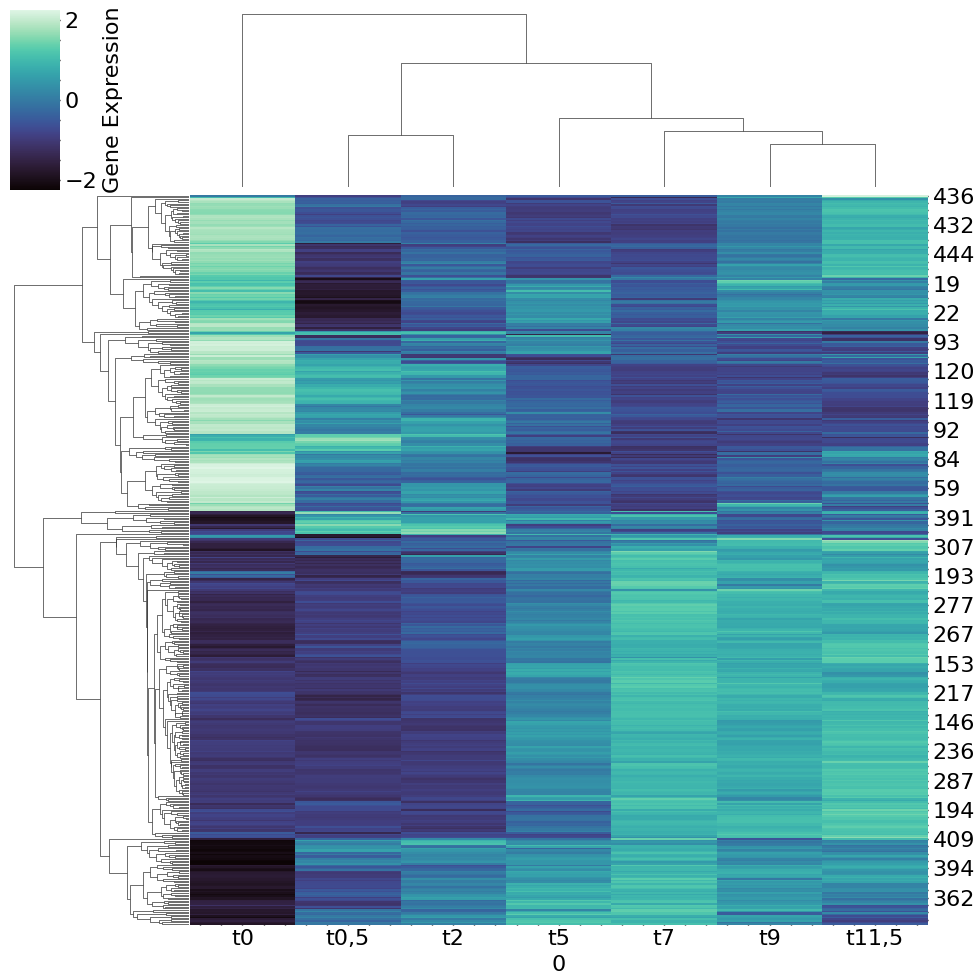

In [79]:
# Create a clustered heatmap with customization
sns.clustermap(data[data.columns[1:]], 
               method='average',       # Hierarchical clustering method
               metric='cityblock',     # Distance metric
               z_score=None,           # No z-score normalization
               standard_scale=None,    # No standard scaling
               figsize=(10, 10),       # Figure size
               cbar_kws={'label': 'Gene Expression'},  # Customize color bar
               row_cluster=True,       # Cluster rows
               col_cluster=True,       # Cluster columns
               dendrogram_ratio=0.2,   # Ratio for dendrogram
               cbar_pos=(0.02, 0.8, 0.05, 0.18),  # Position of color bar
               cmap='mako')         # Custom color map

# Show the heatmap
plt.show()

This clustered heatmap, applies hierarchical clustering to both axis, X (*timestamps*), and Y, (*Gene Expression Levels*). The clustering produced along the X-axis supports out previous hypothesis formulated in the *boxplot* section. Timestamps `t11,5`, `t9`, and `t7` are closely related, as seen in the dendrogram, this is because the gene expression levels are similar, meaning the sporulation process stabilized by that time. `t0` is the last timestamp to join the dendrogram, indicating that the sporulation process at that time was unstable, and gene expression levels have not coordinated yet.

The Y-axis joins genes with similar expression levels, this is useful since we can also see two main groups at `t0`, one, with high expression levels, and the other, with lower values. This two groups get mixes as time progresses. We may also notify that most genes that were really active during `t0` keep low expression levels for the rest of the sporulation process.

4. **Normalization** 

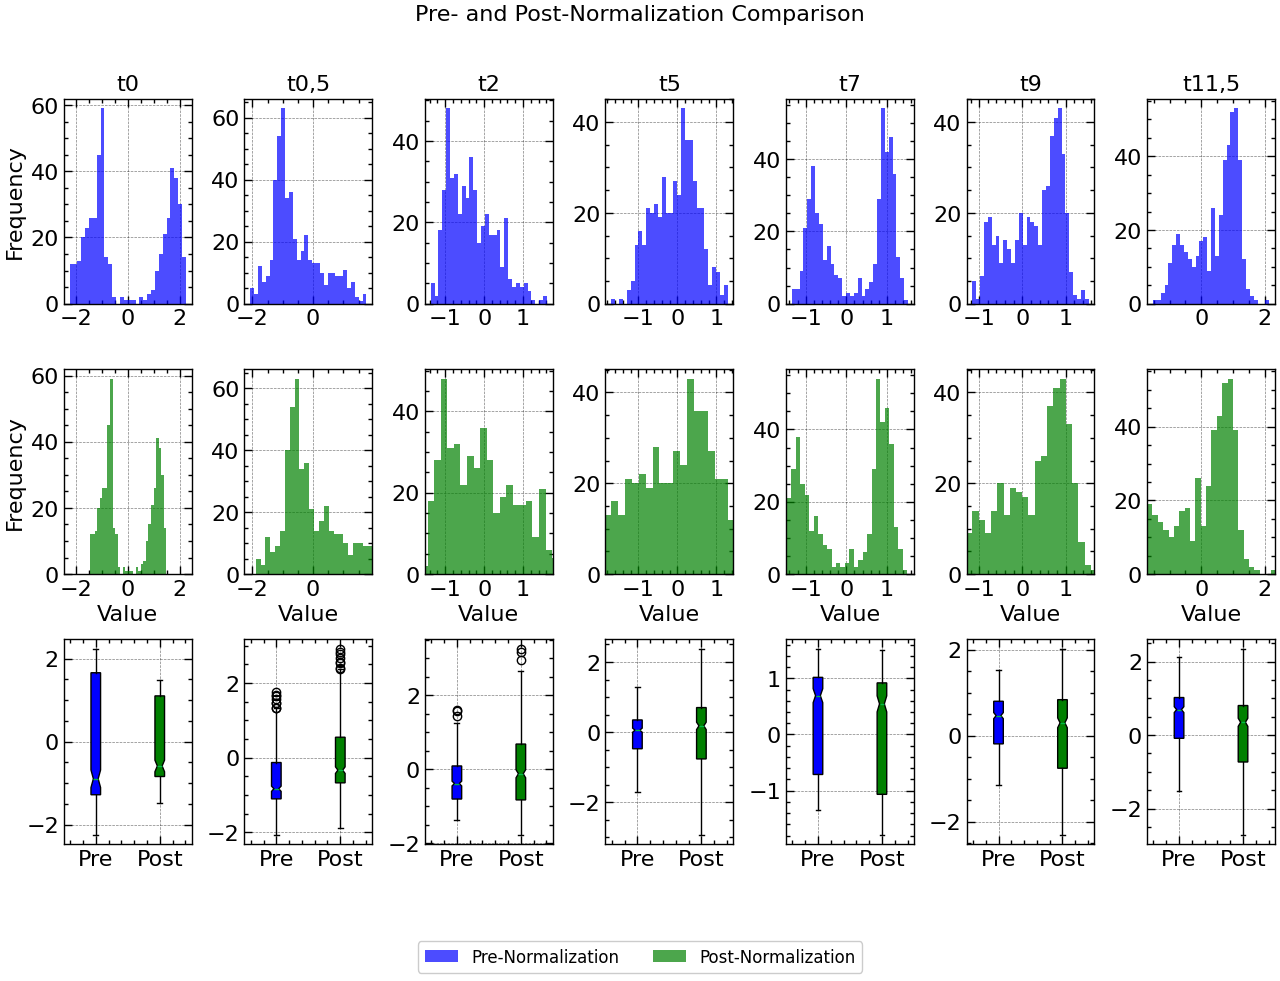

In [80]:

def normalize_data_and_plot(data: pd.DataFrame, columns_to_normalize: list):
    """
    Normalizes the specified columns in the dataset using z-score normalization, 
    plots pre- and post-normalization data with shared x-axis range, and includes
    a boxplot for both sets of data.

    Parameters:
    - data: pd.DataFrame, the dataset containing gene expression data
    - columns_to_normalize: list, list of column names that will be normalized
    
    Returns:
    - normalized_data: pd.DataFrame, the dataframe with normalized values for the specified columns
    """
    
    # Separating the columns to normalize
    pre_norm_data = data[columns_to_normalize].copy()
    
    # Applying z-score normalization
    scaler = StandardScaler()
    normalized_data = pd.DataFrame(scaler.fit_transform(pre_norm_data), columns=columns_to_normalize)
    
    # Plotting pre- and post-normalization data
    fig, axes = plt.subplots(nrows=3, ncols=len(columns_to_normalize), figsize=(13, 10))
    fig.suptitle("Pre- and Post-Normalization Comparison", fontsize=16)
    
    for i, column in enumerate(columns_to_normalize):
        # Pre-normalization plot
        axes[0, i].hist(pre_norm_data[column], bins=30, color='blue', alpha=0.7, label='Pre-Normalization')
        axes[0, i].set_title(f'{column}')
        #axes[0, i].set_xlabel('Value')
        axes[0, 0].set_ylabel('Frequency')
        
        # Getting the x-axis limits from pre-normalization data
        x_min, x_max = axes[0, i].get_xlim()
        
        # Post-normalization plot
        axes[1, i].hist(normalized_data[column], bins=30, color='green', alpha=0.7, label='Post-Normalization')
        #axes[1, i].set_title(f'Post-Normalization: {column}')
        axes[1, i].set_xlabel('Value')
        axes[1, 0].set_ylabel('Frequency')
        
        # Setting the same x-axis range for post-normalization
        axes[1, i].set_xlim(x_min, x_max)
        
        # Boxplot for pre- and post-normalization
        boxplots = axes[2, i].boxplot([pre_norm_data[column], normalized_data[column]], patch_artist=True, notch=True)
        axes[2, i].set_xticklabels(['Pre', 'Post'])
        #axes[2, i].set_title(f'Boxplot: {column}')
        
        # Coloring the boxplots
        boxplots['boxes'][0].set_facecolor('blue')  # Pre-normalization box
        boxplots['boxes'][1].set_facecolor('green')  # Post-normalization box

    # Getting handles and labels from both pre- and post-normalization plots
    pre_handles, pre_labels = axes[0, 0].get_legend_handles_labels()
    post_handles, post_labels = axes[1, 0].get_legend_handles_labels()

    # Common legend for both pre- and post-normalization
    fig.legend(pre_handles + post_handles, pre_labels + post_labels, loc='lower center', ncol=2, fontsize=12)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.96])  # Adjust layout to leave space for the legend
    plt.show()

    return normalized_data

data_normalized = normalize_data_and_plot(data=data, columns_to_normalize=data.columns[1:])

#### Clustering with K-Means

In the original paper, the implemented K-Means had these characteristics included:
1. **Fixed *k* value**. The number if clusters is fixed to 7, even though the paper explores the performance of the algorithm for different values of *k*. 
> *"... Chu et al. (1998) advocated grouping the expressed genes into seven temporal classes on biological grounds. Following Chu et al.(1998), the number of clusters was set to seven in each case..."*
2. **Correlation as distance measure (?)**. The paper does not explicitly mention the distance measure applied for K-Means, however, in the UPGMA section, it mentions that the distance between a pair of genes would be computed as the inverse of the statistical correlation between them.
> *"... The ‘distance’ between genes x and y were taken to be d(x , y) = 1 − | corr(x , y)|, where corr(x , y) is the statistical correlation between the expression profiles of x and y..."*
3. **Initial initial centroids**. The paper mentions that *K-Means* initial centroids for the sporulation dataset were taken from the results of the UPGMA algorithm. 
> *"... K-means is a popular algorithm that uses a reasonable objective criterion. However, it could be sensitive to the choice of the initial cluster centers. For the simulated data sets, we have observed that the K-means algorithm failed when the initial centers were taken to be the cluster means obtained using UPGMA, and, subsequently, we had used the cluster means from Diana for it to work ..."*

In order to replicate the results from the paper as faithfully as possible, we must then complete all these tasks:
- *Obtain the centroids for each k-value we will use to measure the performance of K-Means*. For these, we must compute the UPGMA algorith with `method=average` with a initial distance matrix computed using $d(x , y) = 1 − | corr(x , y)|$ and saving each centroid for every iteration. 

##### Centroids

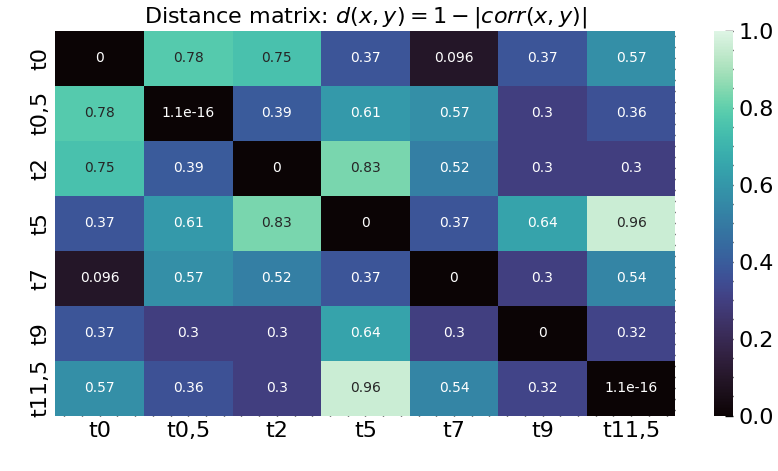

In [81]:
def visualize_distmatrix_corr(X: np.ndarray) -> None:
    # Compute the correlation matrix
    corr_matrix = np.corrcoef(X, rowvar=False)
    distance_matrix = 1 - np.abs(corr_matrix)
    # Translate it to a Dataframe
    corr_mat = pd.DataFrame(distance_matrix, 
                            columns=data.columns[1:], index=data.columns[1:])
    # Plot the heatmap
    sns.heatmap(corr_mat, cmap='mako', annot=True, vmin=0.0, vmax=1.0)
    plt.xlabel(" ")
    plt.ylabel(" ")
    plt.title("Distance matrix: $d(x,y) = 1 - |corr(x,y)|$")

visualize_distmatrix_corr(X = data[data.columns[1:]].values)

In [82]:
# Function to compute centroids for each step in hierarchical clustering
def calculate_cluster_centers(Z: np.ndarray, X:np.ndarray) -> List[Tuple]:
    n = len(X)  # Number of initial data points (genes)
    
    # Start with each gene in its own cluster
    clusters = [[i] for i in range(n)]  
    cluster_centers = []  # List to store the cluster centroids at each iteration

    # Iterate through each step in the hierarchical clustering process
    for i, (a, b, dist, sample_count) in enumerate(Z):
        # Merge clusters 'a' and 'b'
        new_cluster = clusters[int(a)] + clusters[int(b)]  # Combine clusters 'a' and 'b'

        # Calculate the new cluster centroid as the mean of the rows (genes) in the cluster
        cluster_mean = np.mean(X[new_cluster], axis=0)  # Mean expression across all time points
        
        # Save the current clusters and centroids at this step
        cluster_centers.append((clusters.copy(), new_cluster, cluster_mean, n - i - 1))

        # Add the newly formed cluster to the list of clusters
        clusters.append(new_cluster)

    return cluster_centers

# Function to extract centroids for specified K values
def extract_centroids_for_K_list(cluster_centers_all: List[Tuple], K_list: List[int], X: pd.DataFrame) -> List[Dict[str, Union[List[int], np.ndarray, int]]]:
    result = []

    for K in K_list:
        # Initialize storage for centroids for the current K value
        centroids_at_k = []
        
        # Find the clusters and centroids at the step where we have K clusters
        for clusters, merged_cluster, centroid, k_value in cluster_centers_all:
            if k_value == K:
                # The current iteration gives us K clusters, extract their centroids
                for cluster in clusters[:K]:
                    # Calculate the centroid for each cluster
                    cluster_genes = np.mean(X[cluster], axis=0)  # Compute mean across all genes in the cluster
                    centroids_at_k.append({'Clusters': cluster, 'Centroid': cluster_genes, 'K': K})
        
        # Append all centroids for the current K value to the result list
        result.extend(centroids_at_k)
    
    return result

In [88]:
# Saves a large number of centroid values into a CSV file for further exploration
def extract_centroids(X: pd.DataFrame, K_list: List[int], save_name: str, verbose: bool = False) -> None:
    # Compute the condensed correlation distance matrix
    condensed_corr_mat = pdist(X, metric='correlation')

    # Apply UPGMA hierarchical clustering (average linkage)
    Z = linkage(condensed_corr_mat, method='average')

    # Calculate the centroids at each step of the hierarchical clustering
    cluster_centers_all = calculate_cluster_centers(Z, X)

    # Extract centroids for the specified K values
    centroids_for_k_list = extract_centroids_for_K_list(cluster_centers_all, K_list, X)

    # Save the centroids for each K value to a CSV file
    df_centroids = pd.DataFrame(centroids_for_k_list)
    df_centroids.to_csv(f'../results/{save_name}_centroids_for_K_values.csv', index=False)

    if verbose: print("Centroids for specified K values saved to 'centroids_for_K_values.csv'")

# Accesses the CSV file with the centroids of the K values and return a dictionary with the K values and its centroids computed using UPGMA
def get_centroids(k:int, path:str = '../results/centroids_for_K_values.csv', verbose:bool=True) -> None:
    # Load the centroids from the CSV file 
    centroid_data = pd.read_csv(path)

    # Filter for the centroids where K == 7
    centroids_k_7 = centroid_data[centroid_data['K'] == k]['Centroid']

    # Clean and convert centroids from string to numeric arrays
    cleaned_centroids = []
    for centroids in centroids_k_7.values:
        # Remove brackets, split on spaces, and convert each element to float
        cent = centroids.strip(" []").split()
        cent = [float(c) for c in cent]
        cleaned_centroids.append(cent)

    # Convert to numpy array for use in K-Means
    cleaned_centroids = np.array(cleaned_centroids)
    if verbose: print(f'Cleaned Centroids for K = {k}:\n{cleaned_centroids}')

    return cleaned_centroids

K_list = np.arange(2, 51, 1)

# Extract centroids for unprocessed data
df = data[data.columns[1:]].values
extract_centroids(X=df, K_list=K_list, save_name='unprocessed_data')
# Extract centroids for normalized data
df = data_normalized[data_normalized.columns[1:]].values
extract_centroids(X=df, K_list=K_list, save_name='normalized_data')


centroids_unprocessed = {}
centroids_normalized = {}
for k in [2,3,4,5,6,7,8,9,10,11]:
    centroids_unprocessed[k] = get_centroids(k, verbose=False, path = '../results/unprocessed_data_centroids_for_K_values.csv')
    centroids_normalized[k] = get_centroids(k, verbose=False, path='../results/normalized_data_centroids_for_K_values.csv')

##### K-Means

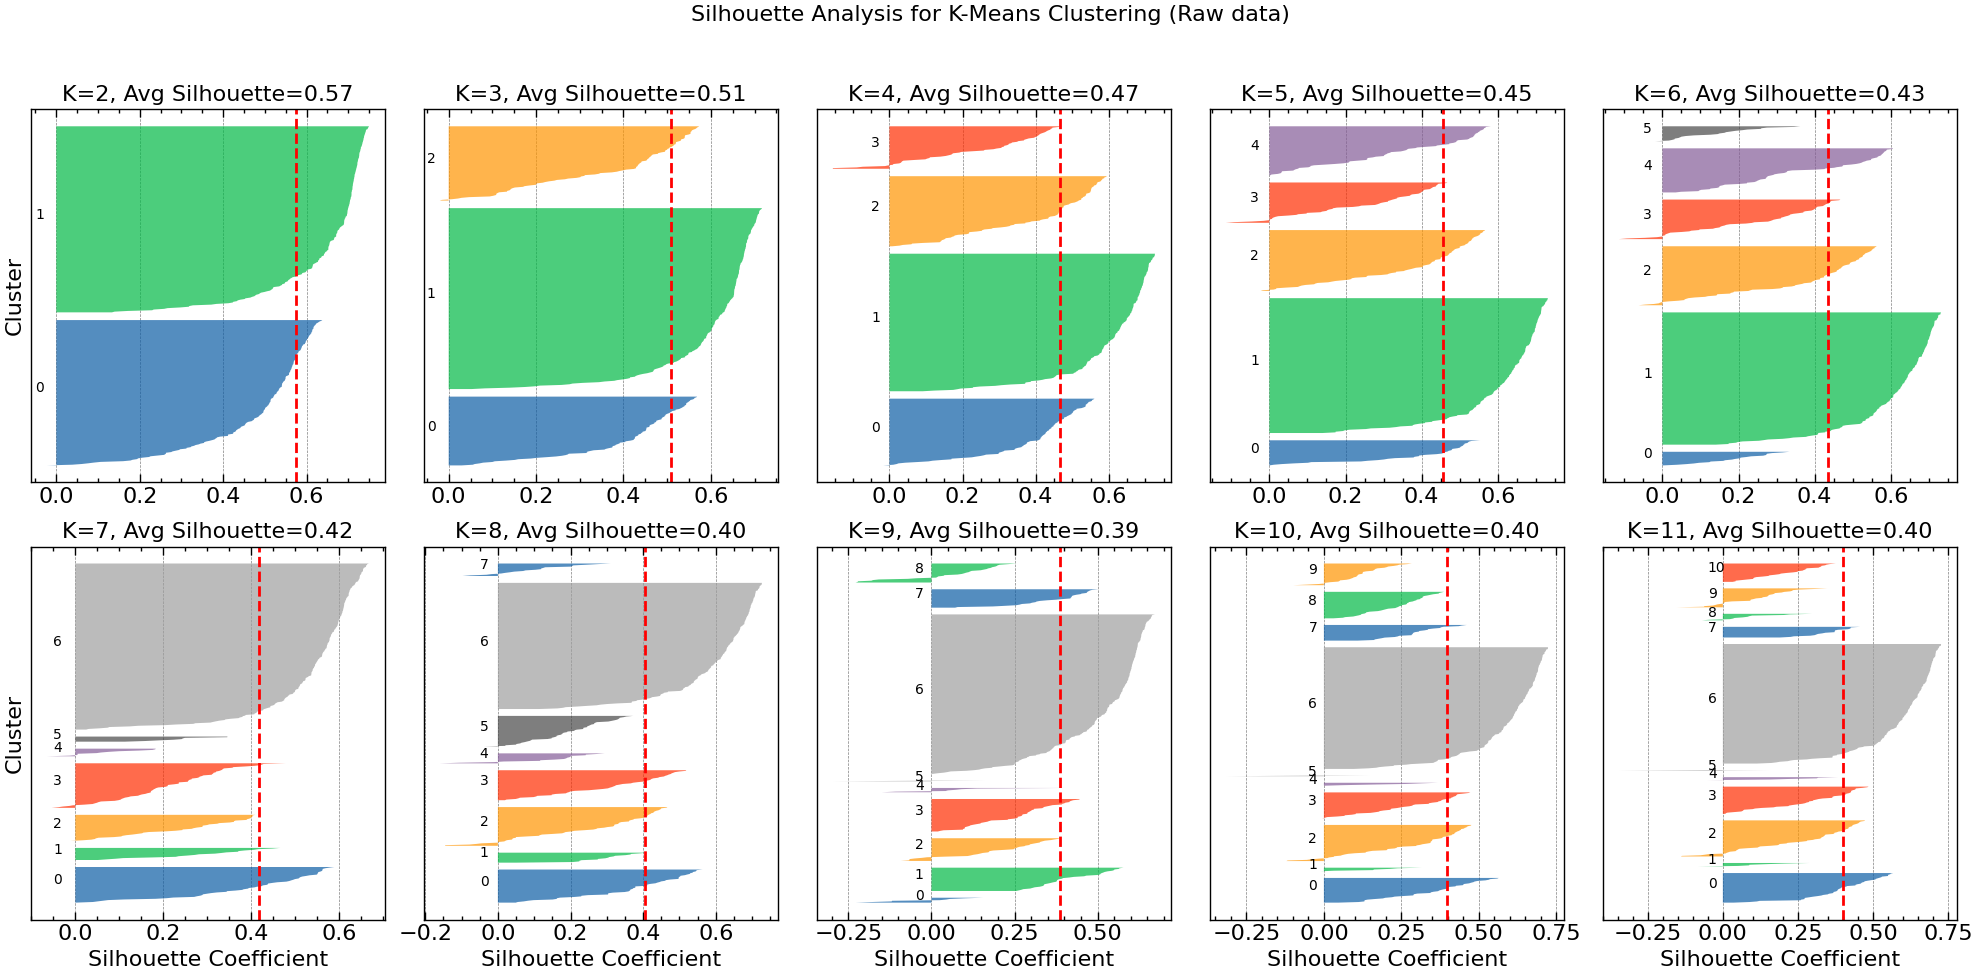

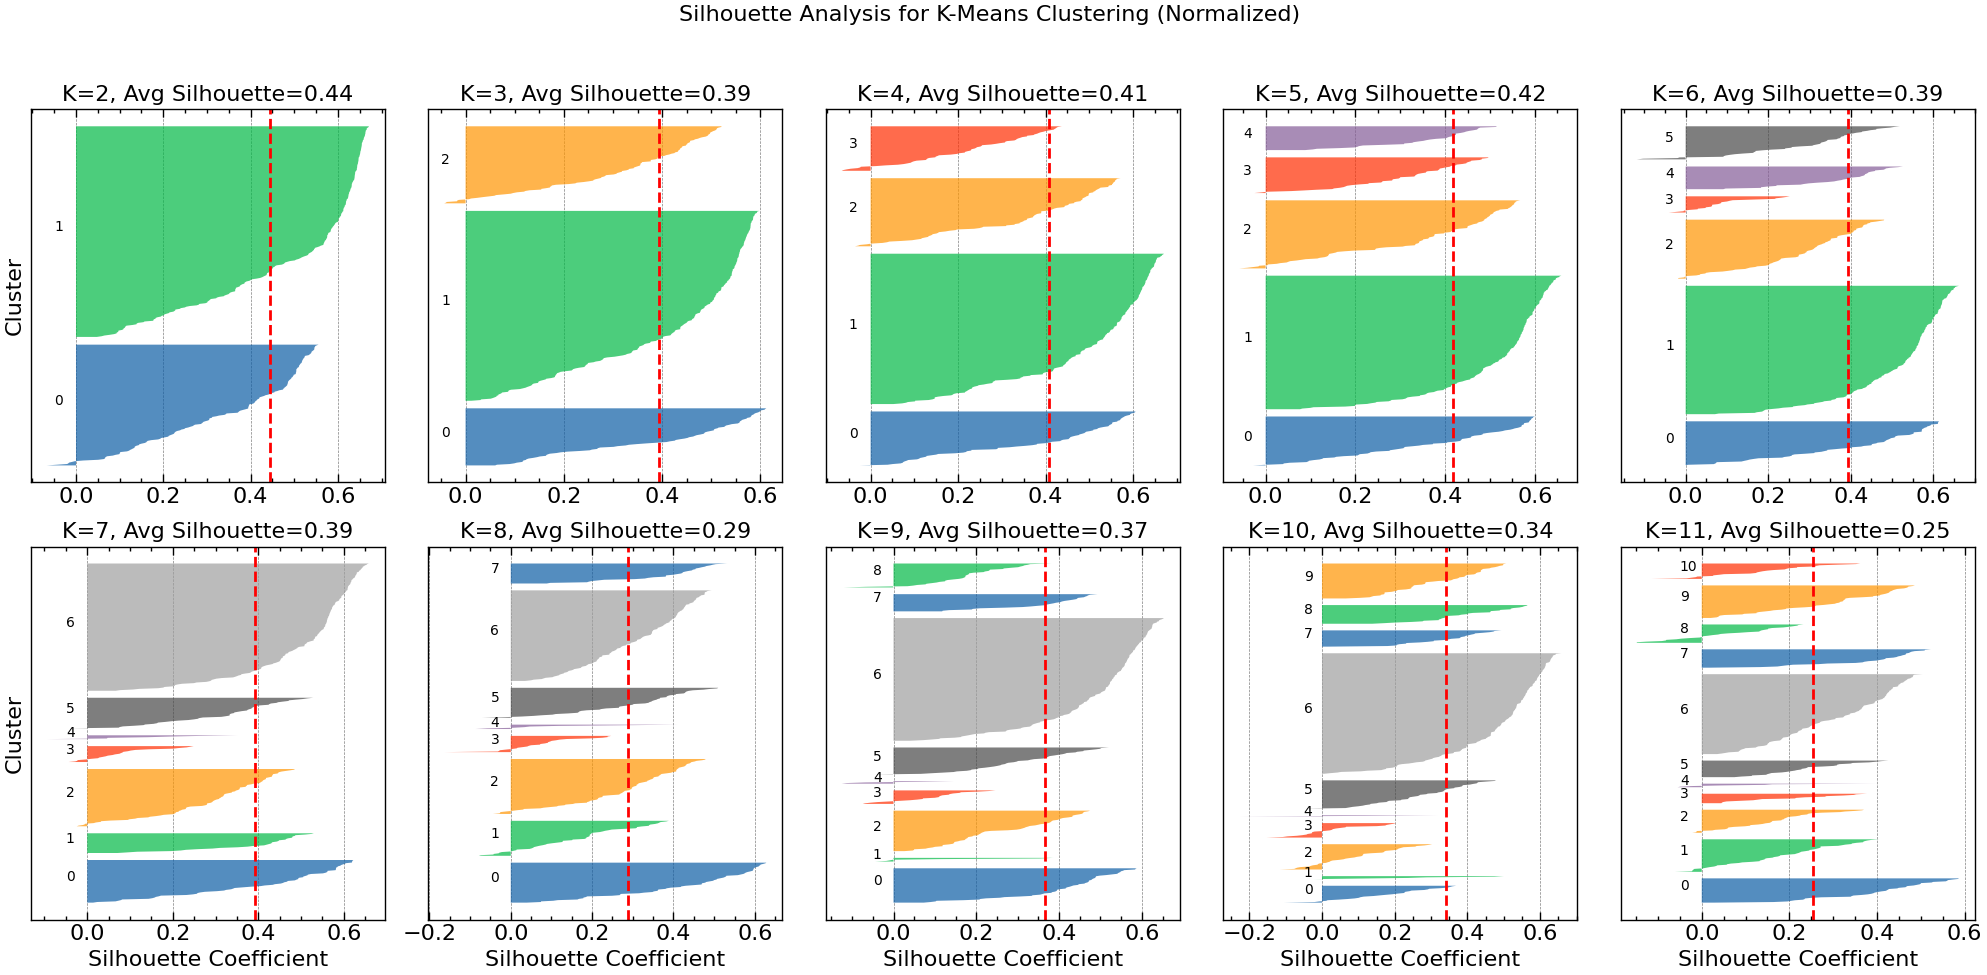

In [89]:
def kmeans_silhouette_analysis(data: pd.DataFrame, k_centroids_dict: dict, title:str = 'Silhouette Analysis for K-Means Clustering'):
    """
    Performs KMeans clustering and silhouette analysis for a range of K values, using 
    the specified initial centroids for each K, returning a DataFrame with the average 
    silhouette score for each K and generating silhouette plots for each K.

    Parameters:
    - data: pd.DataFrame, the dataset containing the feature values.
    - k_centroids_dict: dict, where the keys are K values and the values are the initial centroids for that K.

    Returns:
    - results_df: pd.DataFrame, containing the K values and their corresponding average silhouette score.
    """
    
    X = data.values  # Convert DataFrame to numpy array for KMeans
    
    # Initialize the DataFrame to store results
    results = {
        'K': [],
        'Silhouette Avg': []
    }
    
    # Create a figure for the subplots (2 rows x 5 columns for a maximum of 10 K values)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    
    # Flatten the axes array to easily index it
    axes = axes.flatten()
    
    for idx, (K, initial_centroids) in enumerate(k_centroids_dict.items()):
        # Perform KMeans clustering
        kmeans = KMeans(n_clusters=K, init=initial_centroids, n_init=1, random_state=42)
        kmeans.fit(X)
        labels = kmeans.labels_
        
        # Compute silhouette score and silhouette values
        silhouette_avg = silhouette_score(X, labels)
        silhouette_vals = silhouette_samples(X, labels)
        
        # Store results
        results['K'].append(K)
        results['Silhouette Avg'].append(silhouette_avg)
        
        # Plot the silhouette scores
        ax = axes[idx]
        y_lower = 10
        for i in range(K):
            ith_cluster_silhouette_vals = silhouette_vals[labels == i]
            ith_cluster_silhouette_vals.sort()
            size_cluster_i = ith_cluster_silhouette_vals.shape[0]
            y_upper = y_lower + size_cluster_i
            ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        
        ax.set_title(f'K={K}, Avg Silhouette={silhouette_avg:.2f}')
        
        if idx > 4: ax.set_xlabel('Silhouette Coefficient') 
        if (idx == 0 or idx == 5): ax.set_ylabel('Cluster')
        ax.set_yticks([])
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # Hide any extra subplots that are not used
    for i in range(len(k_centroids_dict), 10):
        fig.delaxes(axes[i])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for the title
    plt.show()
    
    # Convert results to DataFrame and return
    results_df = pd.DataFrame(results)
    return results_df

results_unprocessed = kmeans_silhouette_analysis(data[data.columns[1:]], centroids_unprocessed, title='Silhouette Analysis for K-Means Clustering (Raw data)')
results_normalized = kmeans_silhouette_analysis(data_normalized[data_normalized.columns[1:]], centroids_normalized, title='Silhouette Analysis for K-Means Clustering (Normalized)')

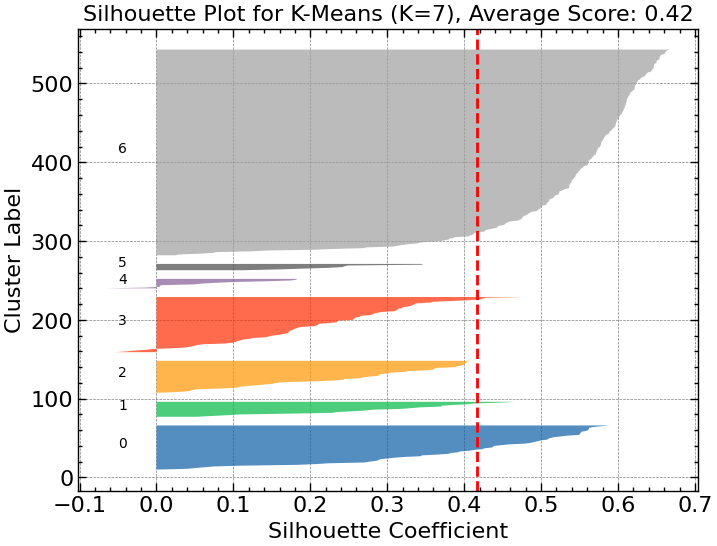

In [51]:
# Assuming your dataset is stored in a pandas DataFrame `data`
X = data[data.columns[1:]].values  # Extract the gene expression values

# Run K-Means using the cleaned centroids for K=7
kmeans = KMeans(n_clusters=7, init=initial_centroids, n_init=1, random_state=42)
kmeans.fit(X)

# Get the cluster labels
labels = kmeans.labels_

# Get the final cluster centroids
final_centroids = kmeans.cluster_centers_

# Compute the silhouette scores for each sample
silhouette_vals = silhouette_samples(X, labels)
silhouette_avg = silhouette_score(X, labels)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(7):
    ith_cluster_silhouette_vals = silhouette_vals[labels == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples gap

plt.title(f'Silhouette Plot for K-Means (K=7), Average Score: {silhouette_avg:.2f}')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster Label')
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()



Silhouette Score for K=2: 0.5739
Silhouette Score for K=3: 0.5098
Silhouette Score for K=4: 0.4666
Silhouette Score for K=5: 0.4548
Silhouette Score for K=6: 0.4339
Silhouette Score for K=7: 0.4169
Silhouette Score for K=8: 0.4043
Silhouette Score for K=9: 0.3870
Silhouette Score for K=10: 0.3962


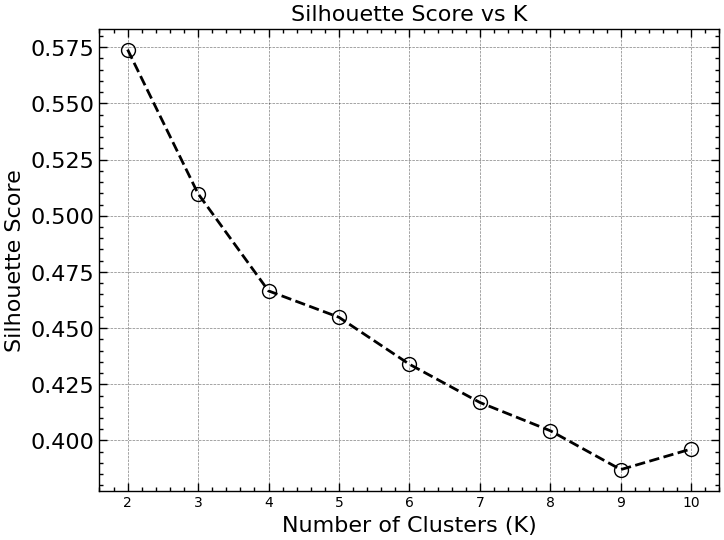

In [52]:
# Store silhouette scores for each K
silhouette_scores = []

k_values_to_try = np.arange(2, 11)
for k in k_values_to_try:
    # Get the initial centroids for this K value
    initial_centroids = get_centroids(k=k, verbose=False)
    
    # Run K-Means with the loaded centroids for the given K
    kmeans = KMeans(n_clusters=k, init=initial_centroids, n_init=1, random_state=42)
    kmeans.fit(X)
    
    # Predict the cluster labels
    labels = kmeans.labels_
    
    # Calculate the silhouette score
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
    print(f"Silhouette Score for K={k}: {score:.4f}")

marker_style = dict(marker='o', markersize=10, fillstyle='none')

# Plot the silhouette scores against K values
plt.figure(figsize=(8, 6))
plt.plot(k_values_to_try, silhouette_scores, linestyle='--', color='black', **marker_style)
plt.title('Silhouette Score vs K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values_to_try, fontsize=10)
plt.grid(True)
plt.show()